In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import time
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# 讀檔

In [3]:
train = 'train.txt'
val = 'val.txt'
test  = 'test.txt'
train = pd.read_csv(train, delimiter = " ",header=None)
val = pd.read_csv(val, delimiter = " ",header=None)
test = pd.read_csv(test, delimiter = " ",header=None)

train.columns = ['image','label']
val.columns = ['image','label'] 
test.columns = ['image','label']

# Feature extraction 

In [4]:
hog = cv2.HOGDescriptor(_winSize = (64,64),
                        _blockSize = (16,16),
                        _blockStride=(16,16),
                        _cellSize= (8,8),
                        _nbins=8)

def feature_extraction(img_path, color_hist = True,  Edge_Detection = True, HOG_Descriptor=True):
    
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_hist_flatten,img_edges_flatten,img_hog_flatten = np.array([]),np.array([]),np.array([])
    # color_hist
    if color_hist ==   True :
        img_hist = cv2.calcHist([img_gray],[0],None,[256],[0,256])
        img_hist_flatten = img_hist.flatten()
    
    # Edge Detection
    if Edge_Detection == True:

        img_small = cv2.resize(img_gray, (16,16))
        # Blur the image for better edge detection
        img_blur = cv2.GaussianBlur(img_small, (3,3), 0) 
        # Canny Edge Detection
        img_edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
        img_edges_flatten = img_edges.flatten()

    
    # HOG Descriptor
    if HOG_Descriptor == True:
        img_resize = cv2.resize(img_gray, (64,64))
        img_hog = hog.compute(img_resize)
        img_hog_flatten = img_hog.flatten()
    
    img_fea = np.concatenate((img_hist_flatten, img_edges_flatten,img_hog_flatten), axis=None)
    
    return img_fea

In [5]:
train['image'] = train['image'].apply(feature_extraction,args= (True,True,True))
val['image'] = val['image'].apply(feature_extraction,args= (True,True,True))
test['image'] = test['image'].apply(feature_extraction,args= (True,True,True))

In [6]:
X_train = np.array(list(train['image'].values))
y_train = np.array(train['label'])
X_val = np.array(list(val['image'].values))
y_val = np.array(val['label'])
X_test = np.array(list(test['image'].values))
y_test = np.array(test['label'])

## partial_fit

In [7]:
partial_fit_classifiers = {
    "SGD": SGDClassifier(max_iter=5),
    "Perceptron": Perceptron(),
    "NB Multinomial": MultinomialNB(alpha=0.01),
}

In [8]:
cls_stats = {}
for cls_name in partial_fit_classifiers:
    stats = {
        "n_train": 0,
        "val_accuracy": 0.0,
        "val_accuracy_history": [(0, 0)],
        "test_accuracy": 0.0,
        "test_accuracy_history": [(0, 0)],
        "t0": time.time(),
        "val_runtime_history": [(0, 0)],
        "test_runtime_history": [(0, 0)],
        "total_fit_time": 0.0,
    }
    cls_stats[cls_name] = stats

val_stats = {'n_val':X_val.shape[0]}
test_stats = {"n_test":X_test.shape[0]}


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats["t0"]
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train image " % stats
    s += "%(n_val)6d val image " % val_stats
    s += "accuracy: %(val_accuracy).3f " % stats
    s += "%(n_test)6d test image  " % test_stats 
    s += "accuracy: %(test_accuracy).3f " % stats
    s += "in %.2fs (%5d image/s)" % (duration, stats["n_train"] / duration)
    return s

In [9]:
minibatch_size = 6000
iteration = X_train.shape[0]//minibatch_size+1
classes = np.unique(y_train)

for i in range(iteration):
    if i < iteration:
        partial_X_train = X_train[minibatch_size*i:minibatch_size*(i+1)]
        partial_y_train = y_train[minibatch_size*i:minibatch_size*(i+1)]
    else:
        partial_X_train = X_train[minibatch_size*i:]
        partial_y_train = y_train[minibatch_size*i:]
    
    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        cls.partial_fit(partial_X_train, partial_y_train,classes=classes)
        
        # accumulate test accuracy stats
        cls_stats[cls_name]["total_fit_time"] += time.time() - tick
        cls_stats[cls_name]["n_train"] += partial_X_train.shape[0]
        
        tick = time.time()
        cls_stats[cls_name]["val_accuracy"] = cls.score(X_val, y_val)
        cls_stats[cls_name]["val_prediction_time"] = time.time() - tick
        
        acc_history = (cls_stats[cls_name]["val_accuracy"], cls_stats[cls_name]["n_train"])
        cls_stats[cls_name]["val_accuracy_history"].append(acc_history)
        run_history = (cls_stats[cls_name]["val_accuracy"])
        cls_stats[cls_name]["val_runtime_history"].append(run_history)
        
        tick = time.time()
        cls_stats[cls_name]["test_accuracy"] = cls.score(X_test, y_test)
        cls_stats[cls_name]["test_prediction_time"] = time.time() - tick
        
        
        acc_history = (cls_stats[cls_name]["test_accuracy"], cls_stats[cls_name]["n_train"])
        cls_stats[cls_name]["test_accuracy_history"].append(acc_history)
        run_history = (cls_stats[cls_name]["test_accuracy"])
        cls_stats[cls_name]["test_runtime_history"].append(run_history)
        print(progress(cls_name, cls_stats[cls_name]))

    print("\n")

                 SGD classifier : 	  6000 train image    450 val image accuracy: 0.024    450 test image  accuracy: 0.024 in 0.61s ( 9861 image/s)
          Perceptron classifier : 	  6000 train image    450 val image accuracy: 0.036    450 test image  accuracy: 0.020 in 1.19s ( 5033 image/s)
      NB Multinomial classifier : 	  6000 train image    450 val image accuracy: 0.038    450 test image  accuracy: 0.044 in 1.23s ( 4894 image/s)


                 SGD classifier : 	 12000 train image    450 val image accuracy: 0.024    450 test image  accuracy: 0.024 in 1.82s ( 6607 image/s)
          Perceptron classifier : 	 12000 train image    450 val image accuracy: 0.027    450 test image  accuracy: 0.027 in 2.40s ( 4997 image/s)
      NB Multinomial classifier : 	 12000 train image    450 val image accuracy: 0.044    450 test image  accuracy: 0.047 in 2.43s ( 4928 image/s)


                 SGD classifier : 	 18000 train image    450 val image accuracy: 0.038    450 test image  accuracy

In [10]:
def plot_accuracy(x, y, set_name):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title("Classification accuracy on %s" % set_name)
    plt.xlabel("%s" % "Training example")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.plot(x, y)

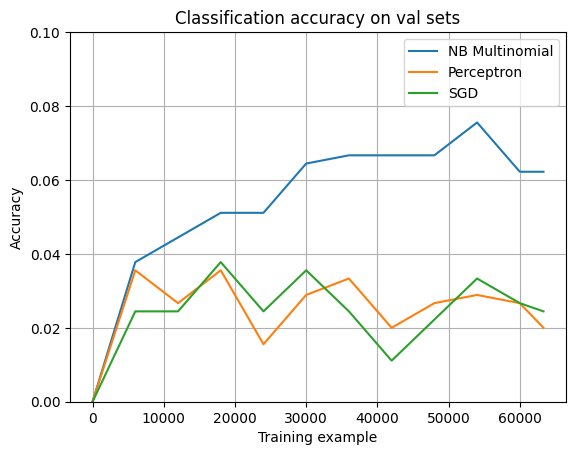

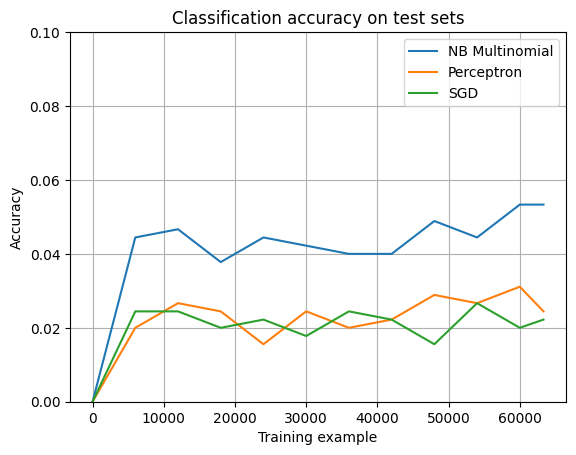

In [11]:
cls_names = list(sorted(cls_stats.keys()))
# Plot accuracy evolution

for i in (["val","test"]):
    plt.figure()
    for _, stats in sorted(cls_stats.items()):
        # Plot accuracy evolution with #examples
        accuracy, n_examples = zip(*stats[f"{i}_accuracy_history"])
        plot_accuracy(n_examples, accuracy, f"{i} sets")
        ax = plt.gca()
        ax.set_ylim((0, 0.1))
    plt.legend(cls_names, loc="best")
    plt.savefig(f"{i}.png")